In [7]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S3

In [8]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [9]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/B_subilis_DNA-damage-30min"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")


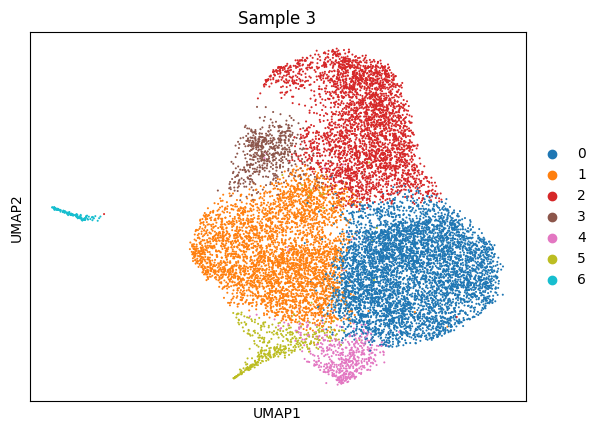

In [10]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [11]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB withou

In [12]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
index                                                           
Sr1    Gene Expression   PA01                125     0.010362   
aadK   Gene Expression   PA01                777     0.063039   
aag    Gene Expression   PA01                157     0.013043   
aapA   Gene Expression   PA01                514     0.042751   
abbA   Gene Expression   PA01               2022     0.176871   
...                ...    ...                ...          ...   
znuB   Gene Expression   PA01                816     0.069778   
znuC   Gene Expression   PA01                330     0.027752   
zosA   Gene Expression   PA01                409     0.034490   
zur    Gene Expression   PA01                660     0.055431   
zwf    Gene Expression   PA01               4854     0.440910   

       log1p_mean_counts  pct_dropout_by_counts  total_counts  \
index                                                           
Sr1             0.010308              99.094269         143.0   
aadK            0.061132              94.369973         870.0   
aag             0.012958              98.862401         180.0   
aapA            0.041862              96.275632         590.0   
abbA            0.162859              85.348888        2441.0   
...                  ...                    ...           ...   
znuB            0.067451              94.087385         963.0   
znuC            0.027374              97.608869         383.0   
zosA            0.033909              97.036447         476.0   
zur             0.053949              95.217738         765.0   
zwf             0.365275              64.828636        6085.0   

       log1p_total_counts  n_cells  var_counts  ...  Protein accession  \
index                                           ...                      
Sr1              4.969813      125    0.013008  ...                NaN   
aadK             6.769642      777    0.073702  ...        NP_390556.1   
aag              5.198497      157    0.016350  ...        NP_391741.1   
aapA             6.381816      514    0.052806  ...        NP_390587.2   
abbA             7.800573     2022    0.216597  ...        NP_389295.1   
...                   ...      ...         ...  ...                ...   
znuB             6.871091      816    0.089400  ...        NP_388169.1   
znuC             5.950643      330    0.036256  ...        NP_388168.1   
zosA             6.167516      409    0.044314  ...                NaN   
zur              6.641182      660    0.069313  ...        NP_390389.2   
zwf              8.713746     4854    0.457508  ...        NP_390266.2   

                                                    Name  Symbol  gene_mean  \
index                                                                         
Sr1                                                  NaN     NaN   0.010362   
aadK                aminoglycoside 6-adenylyltransferase    aadK   0.063039   
aag    3-alkylated purines and hypoxanthine DNA glyco...     aag   0.013043   
aapA                           small amino acid permease    aapA   0.042751   
abbA                         regulator of AbrB repressor    abbA   0.176871   
...                                                  ...     ...        ...   
znuB     high affinity Zn(II) ABC transporter (permease)    znuB   0.069778   
znuC            Zn(II) transporter (ATP-binding protein)    znuC   0.027752   
zosA                                                 NaN     NaN   0.034490   
zur    transcriptional regulator (Zn[2+]-binding Fur ...     zur   0.055431   
zwf    glucose-6-phosphate 1-dehydrogenase (NADP-depe...     zwf   0.440910   

       gene_var  mean_var_diff  gene_dist  est_mean  est_overdisp  \
index                                                               
Sr1    0.013008      -0.002646         nb  0.010365      0.036010   
aadK   0.073702      -0.010663         nb  0.063040      0.351688   
aag    0.016350      -0.003308         nb  0.01303

## Find optimal correlation matrix scaling and generate synthetic null data

In [ ]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 27.410315361183713
Factor: 2 - Error: 17.746287283829584
Factor: 3.6180339999999998 - Error: 19.41913162392386
Factor: 2 - Error: 17.746287283829584
Factor: 2.61803399102434 - Error: 19.46684441392201
Factor: 1.61803399 - Error: 17.637444854741997
Factor: 1.3819660127953202 - Error: 19.148765709880415
Factor: 1.7639320227953201 - Error: 17.518348415014096
Factor: 1.8541019661369627 - Error: 17.600390561943197
Factor: 1.7082039333416426 - Error: 17.543930197968443
Factor: 1.7983738762754533 - Error: 17.512068257712293
Factor: 1.8196601124047755 - Error: 17.533500525369814
Factor: 1.7852182589246421 - Error: 17.53186945501619
Factor: 1.8065044949576883 - Error: 17.552222618908832
Factor: 1.7933488776068771 - Error: 17.515182631161984
Factor: 1.801479496252338 - Error: 17.50394586582215
Factor: 1.8033988749580758 - Error: 17.54553385245634
Factor: 1.8002932549811912 - Error: 17.5129182850021
Factor: 1.8022126336782476 - Error: 17.507328780980735
Factor: 1.80102639240710

In [ ]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [ ]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [ ]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [ ]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

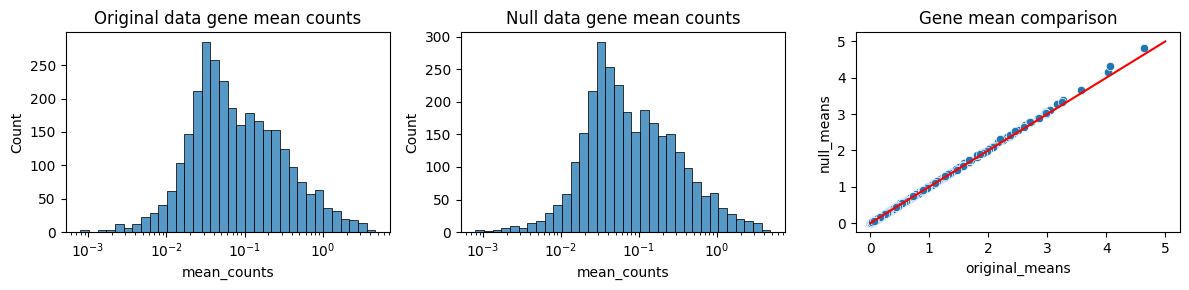

SignificanceResult(statistic=0.9995855144008581, pvalue=0.0)


In [40]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

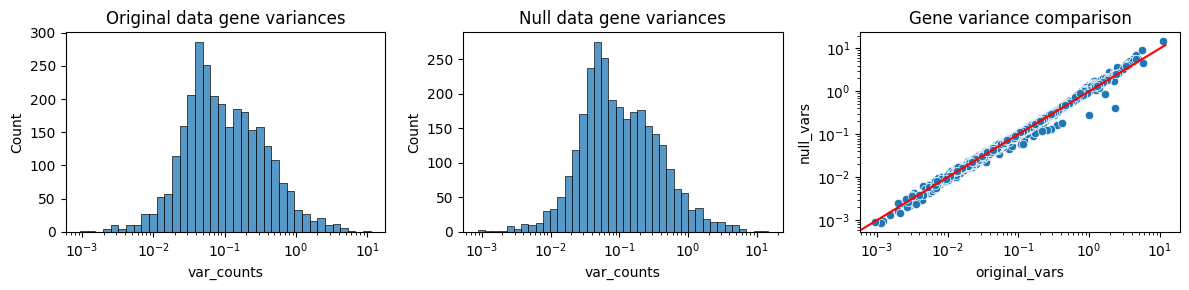

SignificanceResult(statistic=0.998253104591293, pvalue=0.0)
[[1.         0.98669811]
 [0.98669811 1.        ]]


In [41]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

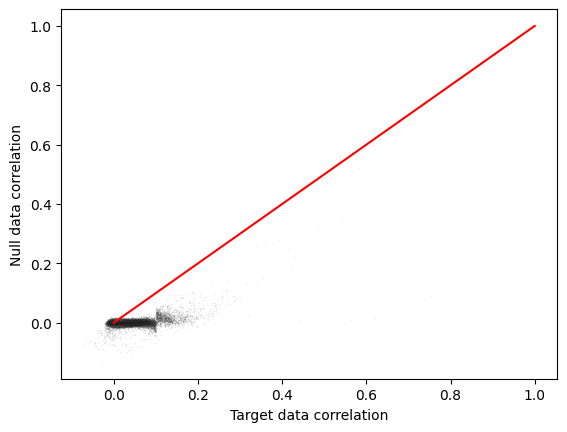

In [42]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [ ]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [ ]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


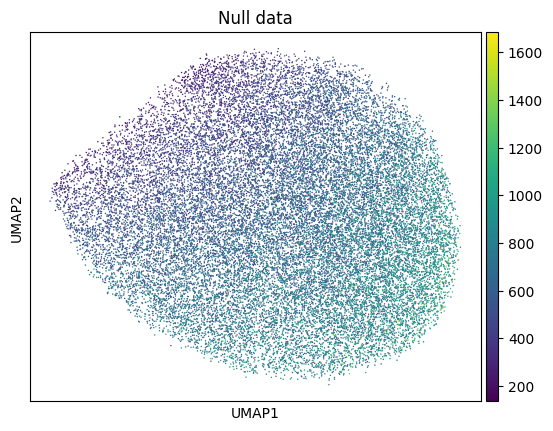

In [43]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [ ]:
data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [ ]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_opt.h5ad")
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

In [ ]:
n_splits = 1
rng = np.random.default_rng(1234)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    was_greater = False
    max_res_1_cluster = 0.01
    
    while twoclust is False:
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        print(f"resolution: {res2}, clusters: {nclust}")

        if nclust == 2:
            twoclust = True
            break
        elif nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 5*res_step
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 15)

            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 5*res_step
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

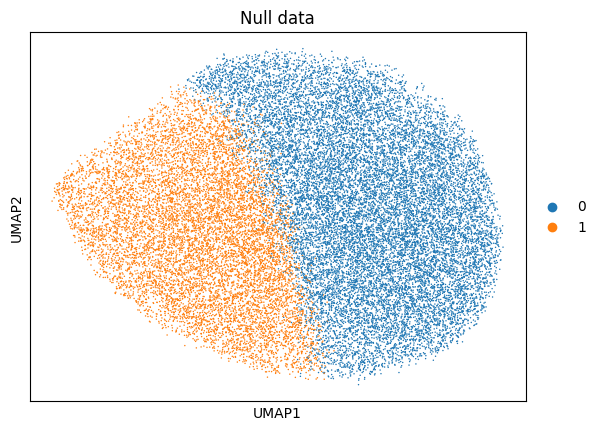

In [44]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [ ]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [45]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 4 - DE genes: 0; Minimum q value: 0.7786259541984732
Cluster 2 - DE genes: 0; Minimum q value: 0.08392434988179669
Cluster 1 - DE genes: 0; Minimum q value: 0.08633921719109747
Cluster 5 - DE genes: 0; Minimum q value: 0.5
Cluster 0 - DE genes: 0; Minimum q value: 0.2632816173013634
Cluster 3 - DE genes: 0; Minimum q value: 1.0
Cluster 6 - DE genes: 0; Minimum q value: 0.1


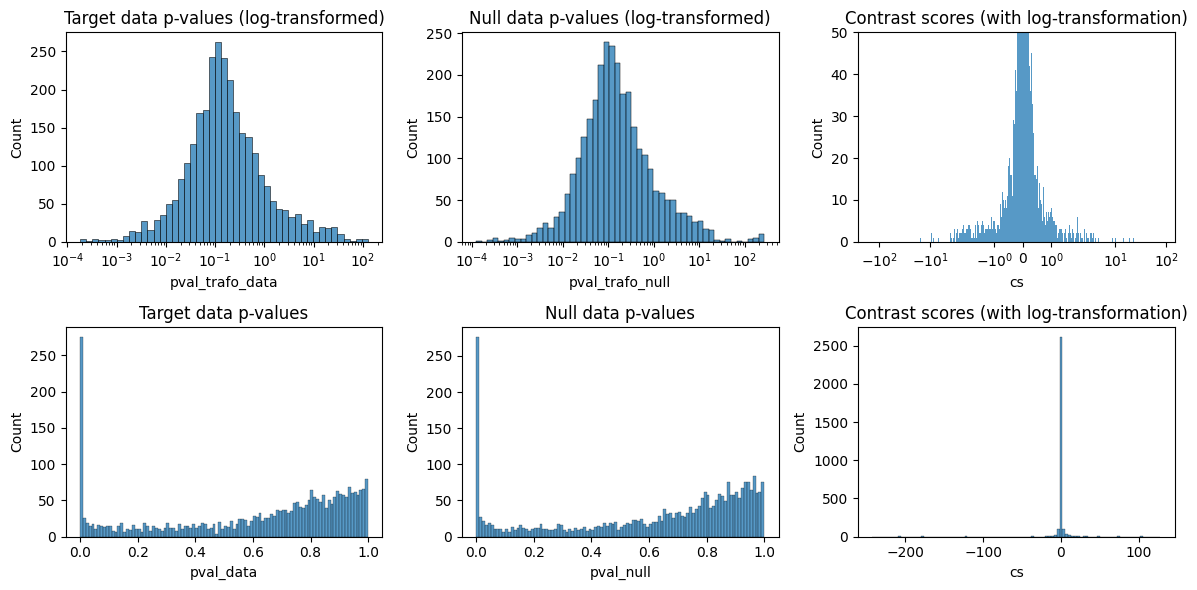

In [46]:
c = "4"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [47]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 4
0.778626     131
0.795455       1
0.812030       1
0.821429       7
0.836879       1
            ... 
0.949096       3
0.949799       1
0.950502       1
0.950560      22
1.000000    1442
Name: q, Length: 81, dtype: int64

cluster 2
0.083924    1692
0.084260      17
0.084647       4
0.084775      21
0.085155       4
            ... 
0.190747       4
0.191481       1
0.191809       1
0.192136       1
1.000000     492
Name: q, Length: 197, dtype: int64

cluster 1
0.086339    2606
0.086623       3
0.086873       4
0.087123       4
0.087686       6
0.088046      12
0.088392       1
0.089841       2
0.090049       5
0.090393       1
0.090943       6
0.091286       1
0.091629       1
0.091971       1
0.092279       2
0.093338       2
0.093433       8
0.093738       2
0.093937       5
0.094241       2
0.094847       4
0.095185       1
0.095522       1
0.096606       1
0.096943       1
0.097134       5
0.097470       1
0.097770       2
0.098032       3
0.098367       1
1.000000     26

In [48]:
pvals_log_gen["0"]

pval_data  pval_null  pval_trafo_data  pval_trafo_null         cs  \
index                                                                         
albA   2.003822e-25   0.156956        24.698141         0.804222  23.893919   
albC   3.232288e-22   0.556360        21.490490         0.254644  21.235846   
yknX   7.537204e-22   0.000008        21.122790         5.086120  16.036670   
albF   2.008280e-17   0.120674        16.697176         0.918386  15.778789   
trpA   2.393511e-16   0.691954        15.620965         0.159923  15.461042   
...             ...        ...              ...              ...        ...   
yosR   0.000000e+00   0.000000              inf              inf        NaN   
yosS   0.000000e+00   0.000000              inf              inf        NaN   
yotC   0.000000e+00   0.000000              inf              inf        NaN   
yotD   0.000000e+00   0.000000              inf              inf        NaN   
yotG   0.000000e+00   0.000000              inf              inf        NaN   

              q  
index            
albA   0.263282  
albC   0.263282  
yknX   0.263282  
albF   0.263282  
trpA   0.263282  
...         ...  
yosR   1.000000  
yosS   1.000000  
yotC   1.000000  
yotD   1.000000  
yotG   1.000000  

[2959 rows x 6 columns]

In [49]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [50]:
data_gene_nonzero.write(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")

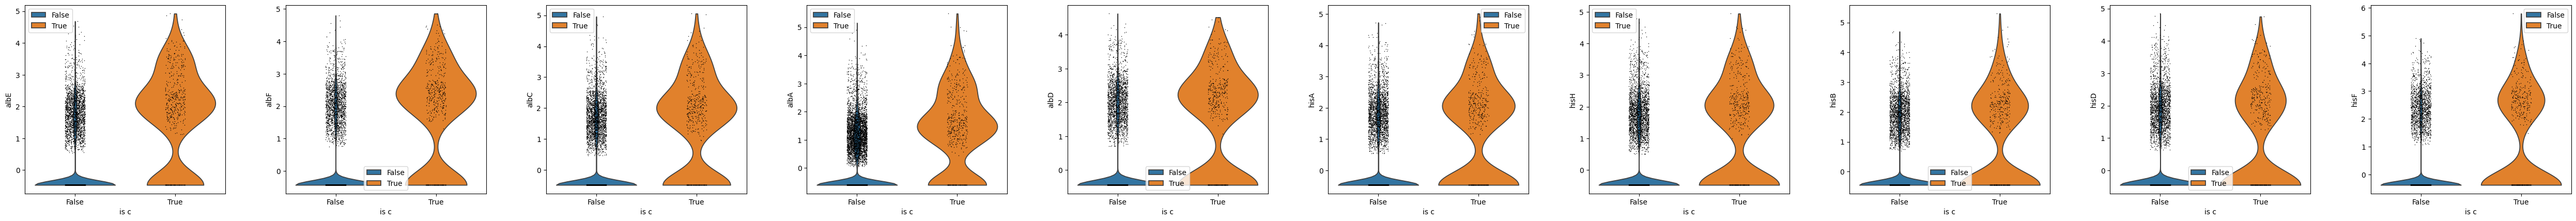

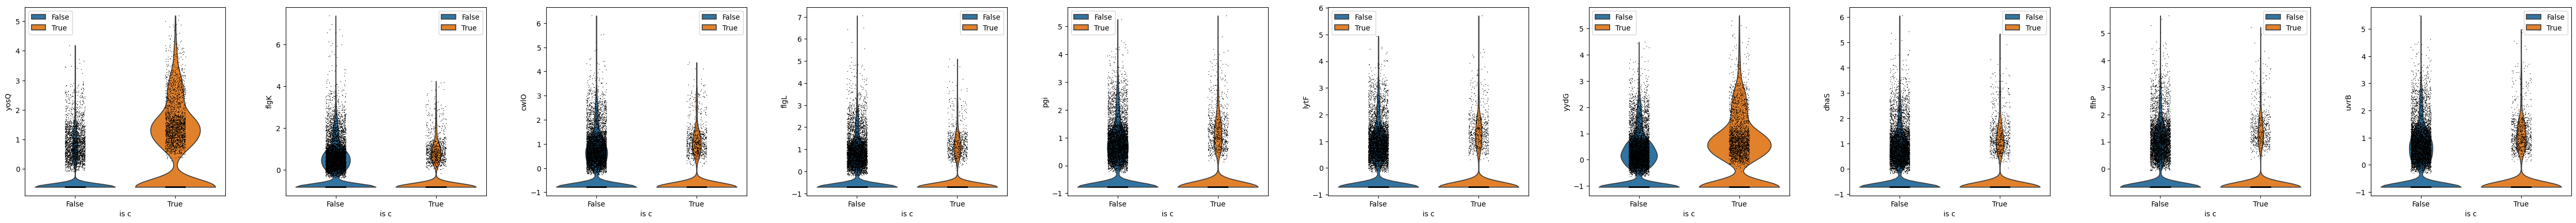

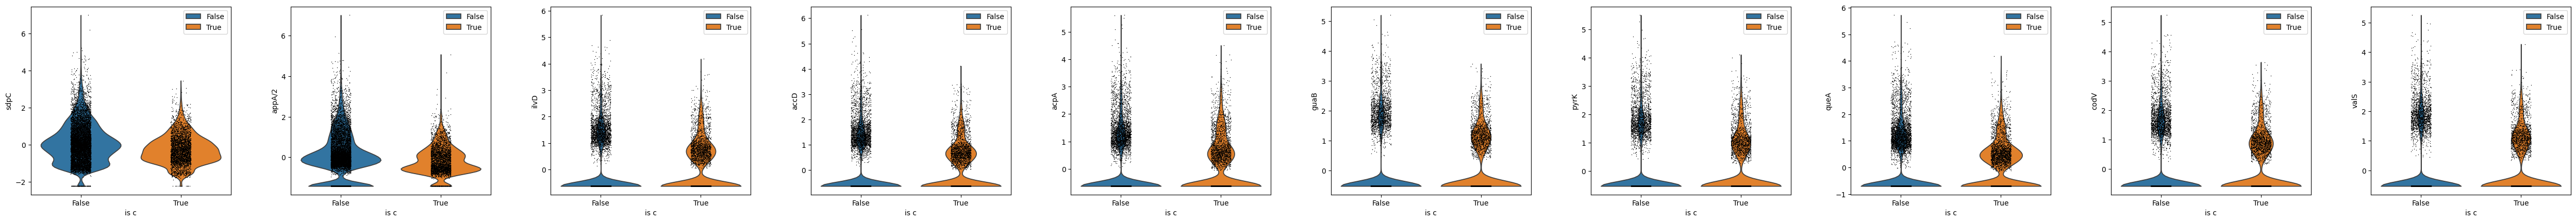

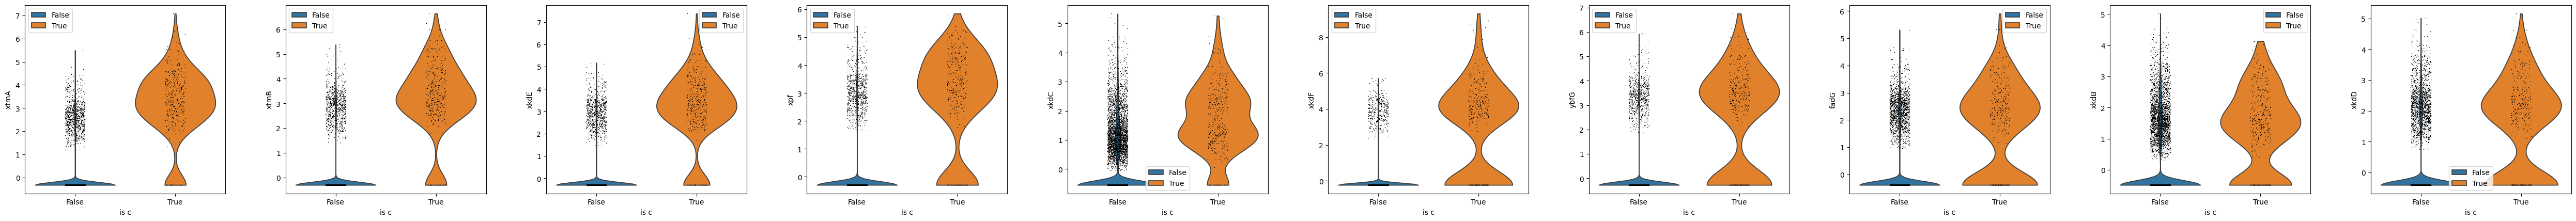

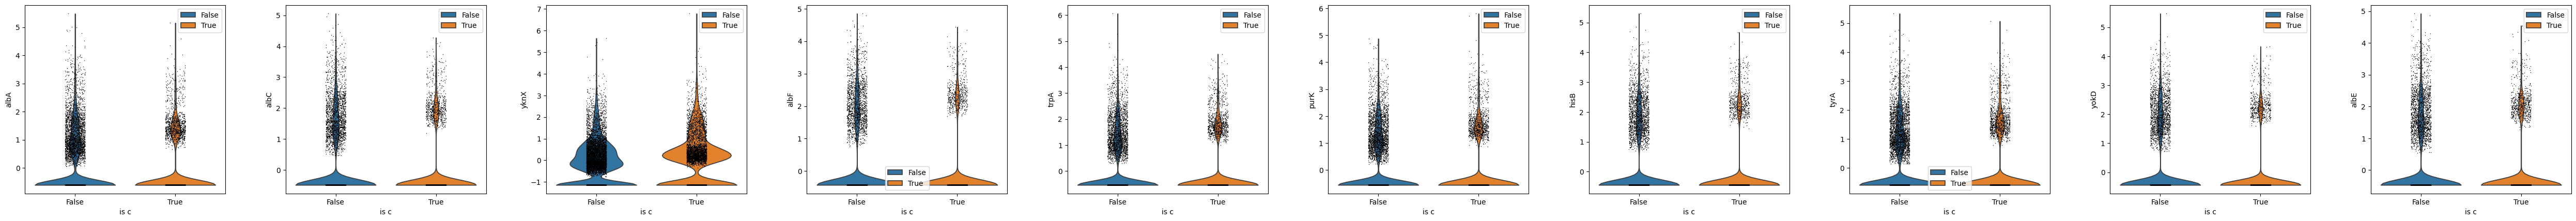

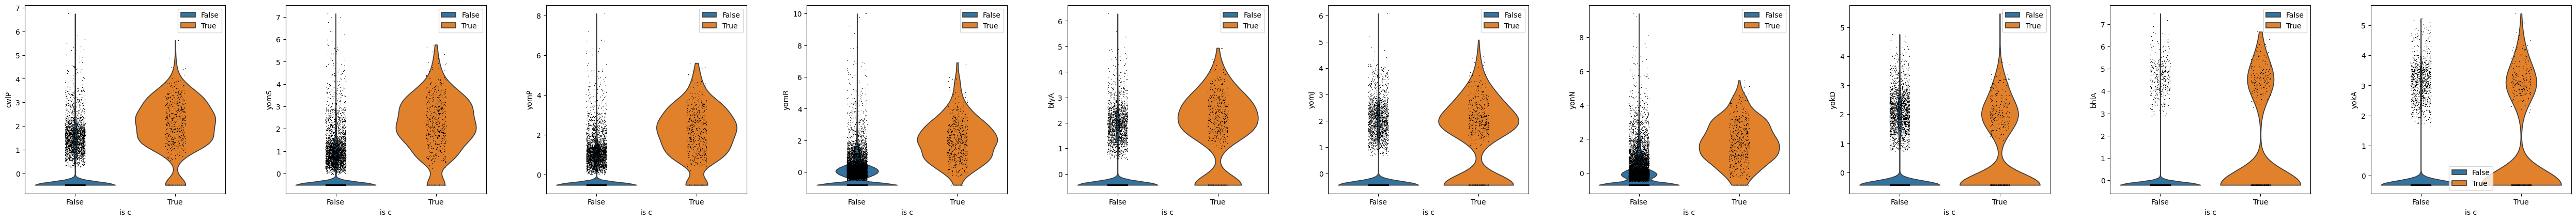

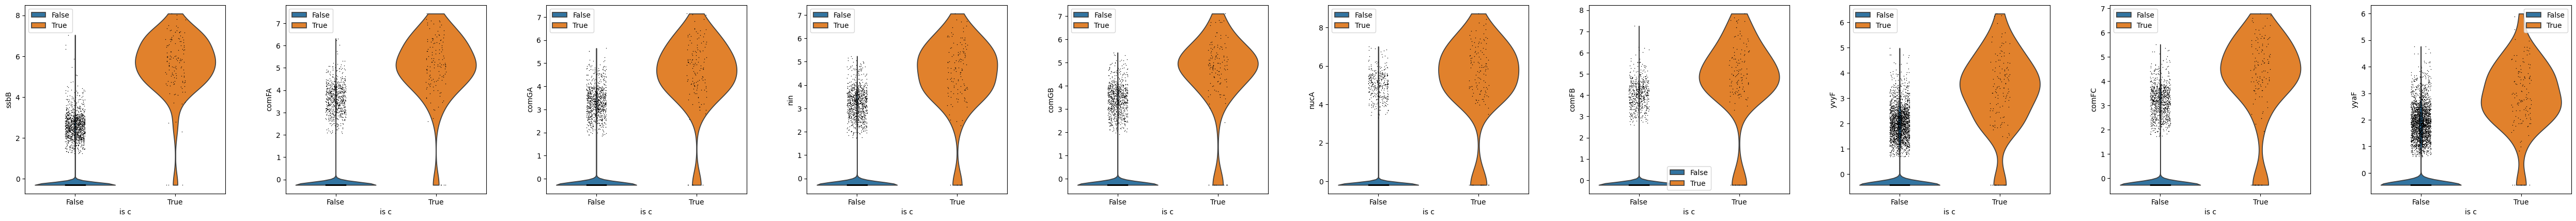

In [51]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [52]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
index                                                           
Sr1    Gene Expression   PA01                125     0.010362   
aadK   Gene Expression   PA01                777     0.063039   
aag    Gene Expression   PA01                157     0.013043   
aapA   Gene Expression   PA01                514     0.042751   
abbA   Gene Expression   PA01               2022     0.176871   
...                ...    ...                ...          ...   
znuB   Gene Expression   PA01                816     0.069778   
znuC   Gene Expression   PA01                330     0.027752   
zosA   Gene Expression   PA01                409     0.034490   
zur    Gene Expression   PA01                660     0.055431   
zwf    Gene Expression   PA01               4854     0.440910   

       log1p_mean_counts  pct_dropout_by_counts  total_counts  \
index                                                           
Sr1             0.010308              99.094269         143.0   
aadK            0.061132              94.369973         870.0   
aag             0.012958              98.862401         180.0   
aapA            0.041862              96.275632         590.0   
abbA            0.162859              85.348888        2441.0   
...                  ...                    ...           ...   
znuB            0.067451              94.087385         963.0   
znuC            0.027374              97.608869         383.0   
zosA            0.033909              97.036447         476.0   
zur             0.053949              95.217738         765.0   
zwf             0.365275              64.828636        6085.0   

       log1p_total_counts  n_cells  var_counts  ...  Protein accession  \
index                                           ...                      
Sr1              4.969813      125    0.013008  ...                NaN   
aadK             6.769642      777    0.073702  ...        NP_390556.1   
aag              5.198497      157    0.016350  ...        NP_391741.1   
aapA             6.381816      514    0.052806  ...        NP_390587.2   
abbA             7.800573     2022    0.216597  ...        NP_389295.1   
...                   ...      ...         ...  ...                ...   
znuB             6.871091      816    0.089400  ...        NP_388169.1   
znuC             5.950643      330    0.036256  ...        NP_388168.1   
zosA             6.167516      409    0.044314  ...                NaN   
zur              6.641182      660    0.069313  ...        NP_390389.2   
zwf              8.713746     4854    0.457508  ...        NP_390266.2   

                                                    Name  Symbol  gene_mean  \
index                                                                         
Sr1                                                  NaN     NaN   0.010362   
aadK                aminoglycoside 6-adenylyltransferase    aadK   0.063039   
aag    3-alkylated purines and hypoxanthine DNA glyco...     aag   0.013043   
aapA                           small amino acid permease    aapA   0.042751   
abbA                         regulator of AbrB repressor    abbA   0.176871   
...                                                  ...     ...        ...   
znuB     high affinity Zn(II) ABC transporter (permease)    znuB   0.069778   
znuC            Zn(II) transporter (ATP-binding protein)    znuC   0.027752   
zosA                                                 NaN     NaN   0.034490   
zur    transcriptional regulator (Zn[2+]-binding Fur ...     zur   0.055431   
zwf    glucose-6-phosphate 1-dehydrogenase (NADP-depe...     zwf   0.440910   

       gene_var  mean_var_diff  gene_dist  est_mean  est_overdisp  \
index                                                               
Sr1    0.013008      -0.002646         nb  0.010365      0.036010   
aadK   0.073702      -0.010663         nb  0.063040      0.351688   
aag    0.016350      -0.003308         nb  0.01303

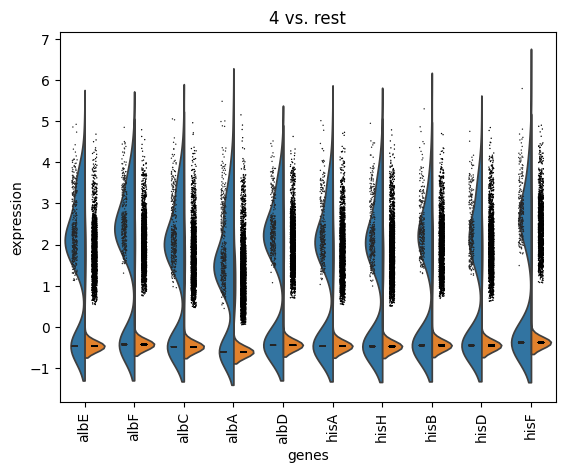

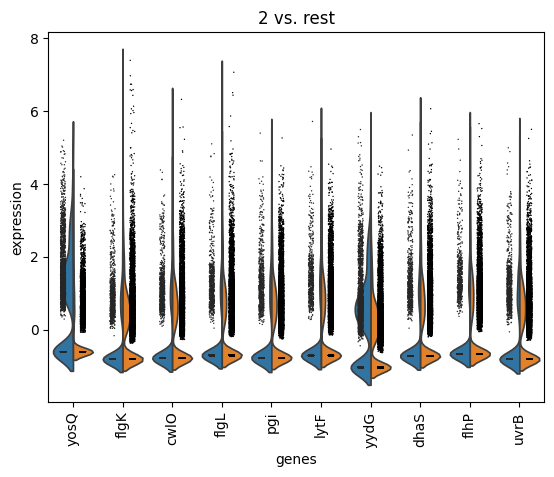

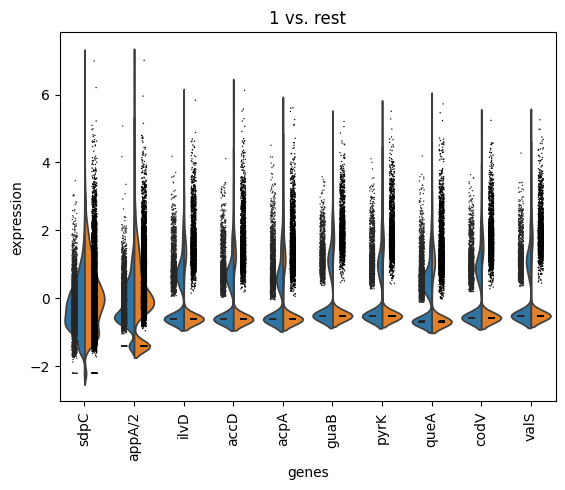

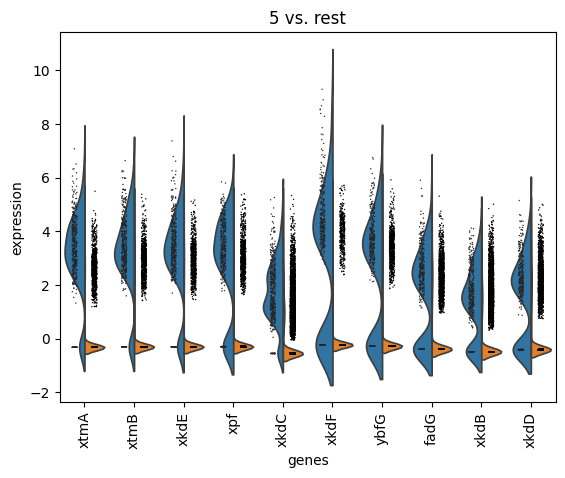

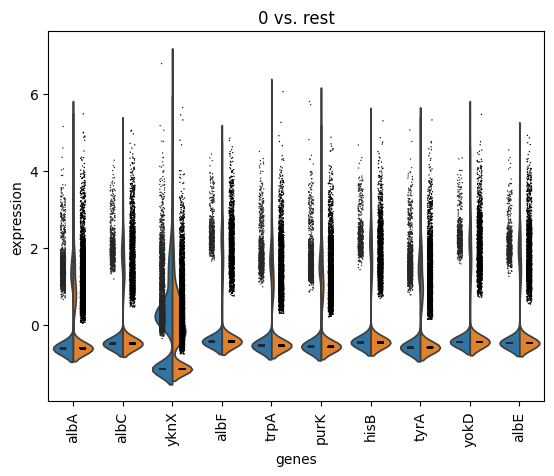

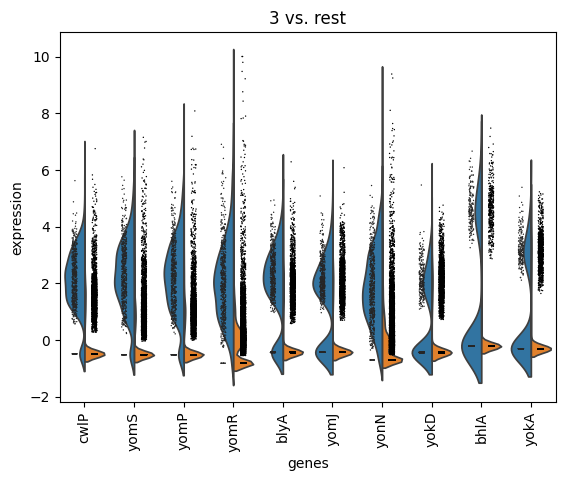

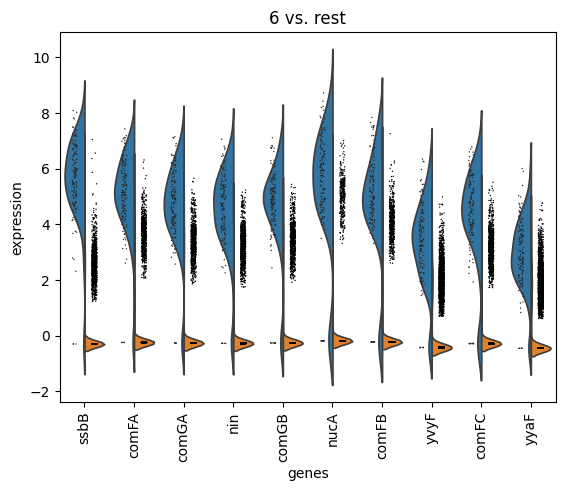

In [53]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [54]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["Locus tag", "Name", "Symbol"]])

Cluster 4
       Locus tag                                               Name Symbol
index                                                                     
albE   BSU_37410      peptidase involved in subtilosin A production   albE
albF   BSU_37420  putative peptidase involved in subtilosin prod...   albF
albC   BSU_37390  putative transporter involved in subtilosin pr...   albC
albA   BSU_37370            subtilosin A thioether formation enzyme   albA
albD   BSU_37400  integral membrane protein involved in subtilos...   albD
hisA   BSU_34880  phosphoribosylformimino-5-aminoimidazole carbo...   hisA
hisH   BSU_34890  imidazole glycerol phosphate synthase, glutami...   hisH
hisB   BSU_34900  imidazoleglycerol-phosphate dehydratase [Mn(II...   hisB
hisD   BSU_34910                           histidinol dehydrogenase   hisD
hisF   BSU_34870      imidazole glycerol phosphate synthase subunit   hisF
Cluster 2
       Locus tag                                               Name Symbol
index

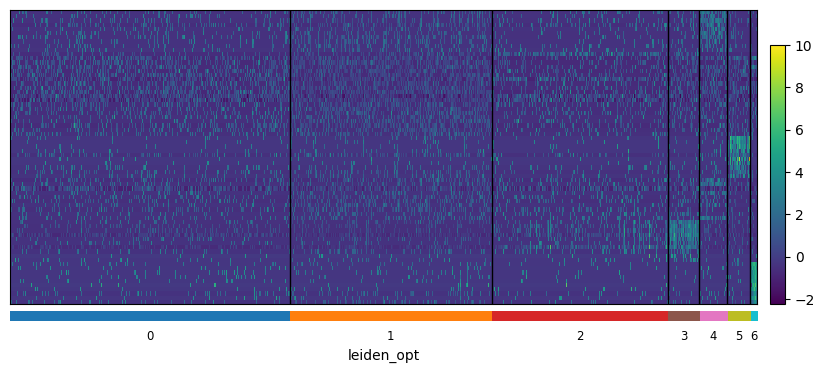

In [55]:
sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True)